# Start of Code For DenseNet and LSTM Paper

# Import Libraries

In [ ]:
# 01
import numpy as np
import h5py
import os
import matplotlib as mpl
print(mpl.__version__)
%matplotlib inline
mpl.style.use('default')
import matplotlib.pyplot as plt
#plt.style.use('classic')
#import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as plt2
from scipy.stats import gennorm, poisson, norm
import scipy.io
from scipy.io import savemat
from scipy.io import loadmat

from keras.layers import Activation, BatchNormalization, Conv2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.layers import MaxPooling2D, Dropout, Input, AveragePooling2D, Reshape, Permute, UpSampling2D, Conv1D, LeakyReLU
from keras.layers import SimpleRNN, Bidirectional, LSTM
from keras.layers import Lambda
from keras.models import load_model, Model
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from keras.optimizers import *
import keras.backend as K
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
K.set_image_data_format('channels_last')


#from tensorflow.keras.optimizers import SGD
from keras.layers import Bidirectional, LSTM, Reshape, Permute, Conv2D, concatenate, Input, Conv2DTranspose, BatchNormalization, Activation, UpSampling2D, Conv1D
from keras.models import load_model, Model

print(keras.__version__)


# QGPU imports

#from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import pandas as pd
import skimage.measure as sk
from matplotlib import cm
from matplotlib.ticker import LinearLocator


# Utilities

In [7]:
# 02
def simulate(size, m_1, m_2, C, A, mu_x, mu_y, sigma_x, sigma_y):
  """
  creates an arbitrary phase map by mixing gaussian blobs and adding ramps
  """
  x = np.arange(0, size[0], 1)
  y = np.arange(0, size[0], 1)
  xx, yy = np.meshgrid(x, y, sparse=True)
  I = np.zeros(size)
  ## mix randomly shaped and placed gaussian blobs
  for i in range(len(sigma_x)):
      a = (xx-mu_x[i])**2/(2*sigma_x[i]**2) + (yy-mu_y[i])**2/(2*sigma_y[i]**2)
      I += A[i]*np.exp(-a)
  ## add ramp phase with random gradients and shifts
  I = m_1*xx + m_2*yy + C + 0.1*I
  return I

def wrap(phi):
  """
  wraps the true phase signal within [-pi, pi]
  """
  return np.angle(np.exp(1j*phi))

def rescale(im, range):
  """
  mini-max rescales the input image
  """
  im_std = (im - im.min()) / (im.max() - im.min())
  im_scaled = im_std * (range[1] - range[0]) + range[0]
  return im_scaled

def create_random_image(size):
  """
  creates an randomly simulated true phase map
  """ 
  array_len = np.random.randint(2, 5)
  m = np.random.uniform(0, 0.5, [2])
  C = np.random.randint(1, 10)
  A = np.random.randint(50, 1000, array_len)
  mu_x = np.random.randint(20, 235, array_len)
  mu_y = np.random.randint(20, 235, array_len)
  sigma_x = np.random.randint(10, 45, array_len)
  sigma_y = np.random.randint(10, 45, array_len)
  I = simulate(size, m[0], m[1], C, A, mu_x, mu_y, sigma_x, sigma_y)
  return I


def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='turbo')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    f.set_facecolor('white')
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='turbo')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
        f.set_facecolor('white')
    plt.show()
    f.colorbar(a, cax=cax)

def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles) 
  plt.show()
  plt.rcParams['figure.facecolor']='white' 

def create_dataset(path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels):
  """
  creates the synthetic true-wrapped phase dataset
  """
  wrapped_phase_maps = np.zeros((1, size[0], size[1]))
  true_phase_maps = np.zeros((1, size[0], size[1])) 

  ## create dataset
  for i in range(no_samples):
      print("Creating {:n}/{:n} pairs".format(i+1, no_samples))

      ## generate the true and wrapped phase maps
      I = create_random_image(size)
      lower_bound = (-2) * np.pi * np.random.randint(1, max_lower_bound+1) 
      upper_bound = 2 * np.pi * np.random.randint(1, max_upper_bound+1) 
      I = rescale(I, [lower_bound, upper_bound])
      I_wrap = wrap(I)      ## generate the true and wrapped phase maps
      I = create_random_image(size)
      lower_bound = (-2) * np.pi * np.random.randint(1, max_lower_bound+1) 
      upper_bound = 2 * np.pi * np.random.randint(1, max_upper_bound+1) 
      I = rescale(I, [lower_bound, upper_bound])
      I_wrap = wrap(I)

      ## adding noise to the true phase before wrapping it
      snr = noise_levels[np.random.randint(0, len(noise_levels))]
      reqSNR = 10**(snr/10)
      sigPower = 1
      sigPower = 10**(sigPower/10)
      noisePower = sigPower/reqSNR
      I_gaun = np.sqrt(noisePower)*norm.rvs(0, 1, size=(256, 256)) # gaussian noise
      I_n = I + I_gaun # noisy true phase
      I_wrap_n = wrap(I_n) # noisy wrapped phase

      wrapped_phase_maps = np.concatenate((wrapped_phase_maps, I_wrap_n.reshape(1, size[0], size[1])), axis=0)
      true_phase_maps = np.concatenate((true_phase_maps, I.reshape(1, size[0], size[1])), axis=0)

      ## adding noise to the true phase before wrapping it
      snr = noise_levels[np.random.randint(0, len(noise_levels))]
      reqSNR = 10**(snr/10)
      sigPower = 1
      sigPower = 10**(sigPower/10)
      noisePower = sigPower/reqSNR
      I_gaun = np.sqrt(noisePower)*norm.rvs(0, 1, size=(256, 256)) # gaussian noise
      I_n = I + I_gaun # noisy true phase
      I_wrap_n = wrap(I_n) # noisy wrapped phase
      ## generate the true and wrapped phase maps
      I = create_random_image(size)
      lower_bound = (-2) * np.pi * np.random.randint(1, max_lower_bound+1) 
      upper_bound = 2 * np.pi * np.random.randint(1, max_upper_bound+1) 
      I = rescale(I, [lower_bound, upper_bound])
      I_wrap = wrap(I)

      ## adding noise to the true phase before wrapping it
      snr = noise_levels[np.random.randint(0, len(noise_levels))]
      reqSNR = 10**(snr/10)
      sigPower = 1
      sigPower = 10**(sigPower/10)
      noisePower = sigPower/reqSNR
      I_gaun = np.sqrt(noisePower)*norm.rvs(0, 1, size=(256, 256)) # gaussian noise
      I_n = I + I_gaun # noisy true phase
      I_wrap_n = wrap(I_n) # noisy wrapped phase

      wrapped_phase_maps = np.concatenate((wrapped_phase_maps, I_wrap_n.reshape(1, size[0], size[1])), axis=0)
      true_phase_maps = np.concatenate((true_phase_maps, I.reshape(1, size[0], size[1])), axis=0)
      wrapped_phase_maps = np.concatenate((wrapped_phase_maps, I_wrap_n.reshape(1, size[0], size[1])), axis=0)
      true_phase_maps = np.concatenate((true_phase_maps, I.reshape(1, size[0], size[1])), axis=0)

  ## save dataset
  no_wrap_counts = max_lower_bound + max_upper_bound + 1
  dataset_id = "Noisy_Phase_Data_{:n}_{:n}pi_{:n}pi.hdf5".format(no_samples, 2*max_lower_bound, 2*max_upper_bound)
  dataset = h5py.File(os.path.join(path, dataset_id), mode='w')
  dataset.create_dataset('psi', data=wrapped_phase_maps[1:, ...])
  dataset.create_dataset('phi', data=true_phase_maps[1:, ...])
  dataset.close()    

# Creating Simulated True Phase Maps

The true phase maps are simulated by randomly setting the parameters of the following equation. 

$$ \phi(x, y) = m_1 x + m_2 y + C + \sum_{n=1}^{N} A_n \exp \Bigg[ - \bigg( \frac{(x - \mu_x)^2}{2\sigma_x^2} + \frac{(y - \mu_y)^2}{2\sigma_y^2} \bigg) \Bigg] \; ; \; \forall (x, y) \in [-128, 127)^2$$ 

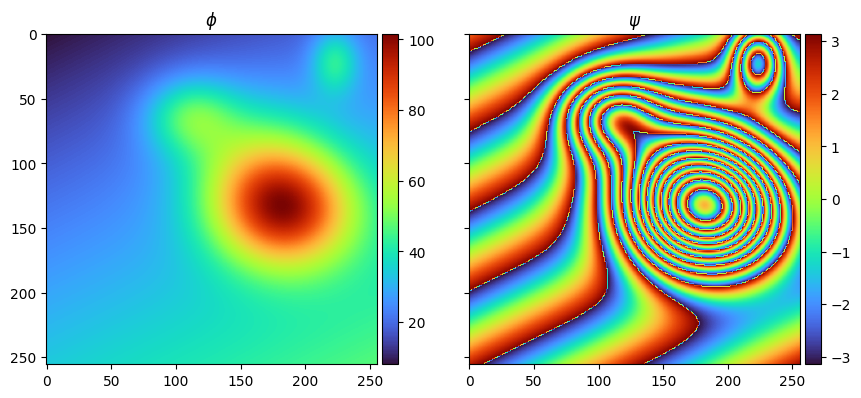

In [3]:
# 03

## example
size = (256, 256)
I = create_random_image(size)
I_wrap = wrap(I)
plot(I, I_wrap, titles=["$\phi$", "$\psi$"])

matOrg = {"data":I,"label": "original data"}
savemat("NoiseFreeData26MarOrig.mat", matOrg)

matWrap = {"data":I_wrap,"label": "wrapped data"}
savemat("NoiseFreeData26MarWrap.mat", matWrap)


Maximum value in I_gaun: 1.631807258150686


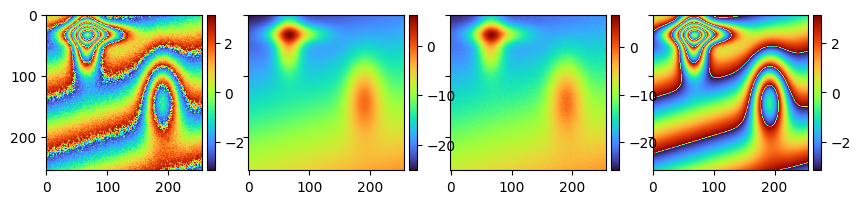

'\nOrigwrap = {"data":I_wrap,"label": "noisy wrapped data"}\nsavemat("03matNoiseFreewrap.mat", Origwrap)\n\nNwrap = {"data":I_wrap_n,"label": "noisy wrapped data"}\nsavemat("04matNoiseNwrap.mat", Nwrap)\n\nNosiss = {"data":I_gaun,"label": "noisy"}\nsavemat("05matNoise.mat", Nosiss)\n\n'

In [20]:
      ## generate the true and wrapped phase maps
noise_levels = [0, 5, 10]
max_lower_bound = 4
max_upper_bound = 4 


I = create_random_image(size)
lower_bound = (-2) * np.pi * np.random.randint(1, max_lower_bound+1) 
upper_bound = 2 * np.pi * np.random.randint(1, max_upper_bound+1) 
I = rescale(I, [lower_bound, upper_bound])
I_nf = I
## adding noise to the true phase before wrapping it
snr = noise_levels[np.random.randint(0, len(noise_levels))]
reqSNR = 10**(snr/10)
sigPower = 1
sigPower = 10**(sigPower/10)
noisePower = sigPower/reqSNR
I_gaun = np.sqrt(noisePower)*norm.rvs(0, 1, size=(256, 256)) # gaussian noise
max_value = np.max(I_gaun)
I= I + I_gaun
I_wrap = wrap(I)
I_wrap_nf = wrap(I_nf)
print("Maximum value in I_gaun:", max_value)
#I_n = I + I_gaun # noisy true phase
#Difference = I-I_n
#I_wrap_n = wrap(I_n) # noisy wrapped phase


#wrapped_phase_maps = np.concatenate((wrapped_phase_maps, I_wrap_n.reshape(1, size[0], size[1])), axis=0)
#true_phase_maps = np.concatenate((true_phase_maps, I.reshape(1, size[0], size[1])), axis=0)

plot(I_wrap , I_nf, I,I_wrap_nf)

#plt.plot(I_gaun, 'k', linewidth=2)

#plt.title('Random Samples from Standard Normal Distribution')
#plt.show()

#data = loadmat("/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/February26_Final Results/Complex_07/Diff_OrigFeb_26.mat")    

#dataset = data['orig']    

#dataset_n = dataset + I_gaun # noisy true phase

#dataset_n_wrap = wrap(dataset_n)

#plot(dataset_n_wrap,dataset_n, titles=["Noisy","True" ])


#Complex_Orig = {"data":dataset_n,"label": "orig_n"}
#savemat("OrigComplex_Mar7.mat", Complex_Orig)

#Complex_wrap = {"data":dataset_n_wrap,"label": "wrap_n"}
#savemat("WrapComplex_Mar7.mat", Complex_wrap)

'''
Origwrap = {"data":I_wrap,"label": "noisy wrapped data"}
savemat("03matNoiseFreewrap.mat", Origwrap)

Nwrap = {"data":I_wrap_n,"label": "noisy wrapped data"}
savemat("04matNoiseNwrap.mat", Nwrap)

Nosiss = {"data":I_gaun,"label": "noisy"}
savemat("05matNoise.mat", Nosiss)

'''

#plot(I, I_n, I_wrap_n, I_gaun,Difference, titles=["True","noisy true","Wrap", "Noise", "Diff"])

In [21]:
Complex_Orig_nf_21June = {"data":I_nf,"label": "orig_nf"}
savemat("OrigDataGenNF_21June103.mat", Complex_Orig_nf_21June)

Complex_wrap_noisy_21June = {"data":I_wrap,"label": "wrap_n"}
savemat("WrapDataGen_21June103.mat", Complex_wrap_noisy_21June)

Complex_Orig_nf_21June= {"data":I_wrap_nf,"label": "wrap_nf"}
savemat("wrapDataGenNF_21June103.mat", Complex_Orig_nf_21June)

Complex_wrap_noisy_21June = {"data":I,"label": "orig_n"}
savemat("OrigDataGen_21June103.mat", Complex_wrap_noisy_21June)

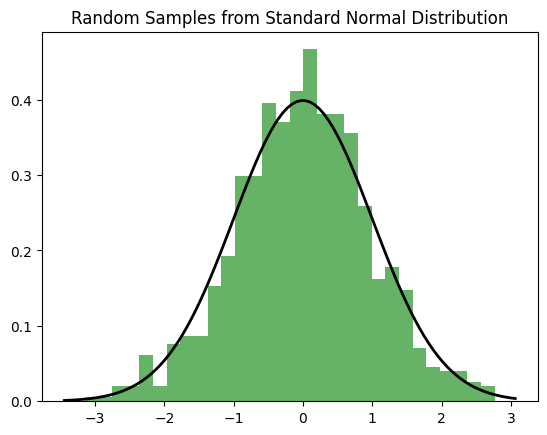

In [12]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Generate 1000 random samples from a standard normal distribution
random_samples = norm.rvs(size=1000)

# Plot a histogram of the generated samples
plt.hist(random_samples, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (pdf) of a standard normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Random Samples from Standard Normal Distribution')
plt.show()

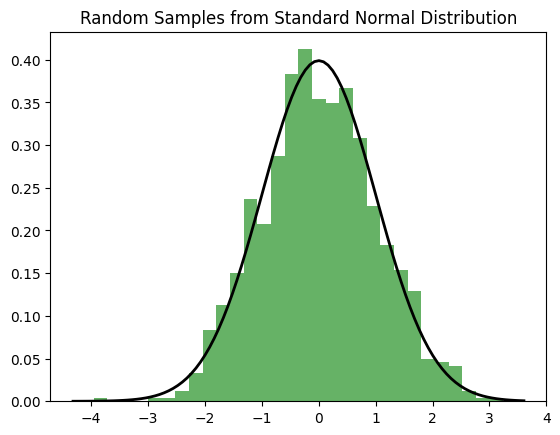

In [13]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Generate 1000 random samples from a standard normal distribution
random_samples = norm.rvs(size=1000)

# Plot a histogram of the generated samples
plt.hist(random_samples, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (pdf) of a standard normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Random Samples from Standard Normal Distribution')
plt.show()

# Creating Noisy Phase Dataset

The noisy phase dataset is created by randomly adding the specified noise levels (SNRs in dB) to the simulated true phase images before wrapping them.

The following code snippet generates a dataset with $1000$ true-wrapped phase maps of size $256 \times 256$. The maximum and minimum values taken by the true phase map pixels are $2 N_u \pi$ and $2 N_l \pi$ respectively. Noise levels including $0, 5, 10, 20$ and $60 \text{ dB}$ were randomly added to the true phase images before wrapping them. ($N_u = \text{maximum upper bound}$, $N_l = \text{maximum lower bound}$)

# Create Training Data

In [4]:
# 04

## create the Training dataset
#save_path = '/content/drive/My Drive/DeepUnwrap'
save_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data'
size = (256, 256)
no_samples = 3000
max_lower_bound = 4
max_upper_bound = 4 
noise_levels = [0, 10, 25, 50, 100]

create_dataset(save_path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels)

Creating 1/3000 pairs
Creating 2/3000 pairs
Creating 3/3000 pairs
Creating 4/3000 pairs
Creating 5/3000 pairs
Creating 6/3000 pairs
Creating 7/3000 pairs
Creating 8/3000 pairs
Creating 9/3000 pairs
Creating 10/3000 pairs
Creating 11/3000 pairs
Creating 12/3000 pairs
Creating 13/3000 pairs
Creating 14/3000 pairs
Creating 15/3000 pairs
Creating 16/3000 pairs
Creating 17/3000 pairs
Creating 18/3000 pairs
Creating 19/3000 pairs
Creating 20/3000 pairs
Creating 21/3000 pairs
Creating 22/3000 pairs
Creating 23/3000 pairs
Creating 24/3000 pairs
Creating 25/3000 pairs
Creating 26/3000 pairs
Creating 27/3000 pairs
Creating 28/3000 pairs
Creating 29/3000 pairs
Creating 30/3000 pairs
Creating 31/3000 pairs
Creating 32/3000 pairs
Creating 33/3000 pairs
Creating 34/3000 pairs
Creating 35/3000 pairs
Creating 36/3000 pairs
Creating 37/3000 pairs
Creating 38/3000 pairs
Creating 39/3000 pairs
Creating 40/3000 pairs
Creating 41/3000 pairs
Creating 42/3000 pairs
Creating 43/3000 pairs
Creating 44/3000 pai

# ==> Model (DenseNet + LSTM + CBAM + CNN Decoder)

# DenseNet for Feature Extraction

In [15]:
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SpatialAttention, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.conv1 = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')

    def call(self, inputs):
        attention = self.conv1(inputs)
        return attention * inputs

In [17]:
# New Code with attention 

input_shape = (256,256,1)

input = Input(input_shape)
densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block
x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    # Apply spatial attention after x_ver_1
x_ver_1_with_attention = SpatialAttention()(x_ver_1)

h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1_with_attention)

H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    # Apply spatial attention after H
H_with_attention = concatenate([c_hor_1, c_ver_1])
H_with_attention = SpatialAttention()(H_with_attention)

    # Decoder Network
    # 8,8,512
u1 = UpSampling2D(size=(2,2))(H_with_attention) # 16,16,512
c1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1) # 16,16,64
b1 = BatchNormalization()(c1)
c2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b1)
b2 = BatchNormalization()(c2)

u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)  # 16,16,64
b3 = BatchNormalization()(c3)
c4 = Conv2D(128, (3, 3), padding='same', activation='relu')(b3)
b4 = BatchNormalization()(c4)
    #
u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
c5 = Conv2D(32, (3, 3), padding='same', activation='relu')(u3)  # 16,16,64
b5 = BatchNormalization()(c5)
c6 = Conv2D(32, (3, 3), padding='same', activation='relu')(b5)
b6 = BatchNormalization()(c6)
    #
u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
c7 = Conv2D(8, (3, 3), padding='same', activation='relu')(u4)  # 16,16,64
b7 = BatchNormalization()(c7)
c8 = Conv2D(8, (1, 1), padding='same', activation='relu')(b7)
b8 = BatchNormalization()(c8)
    #
u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
c9 = Conv2D(1, (1, 1), padding='same', activation='relu')(u5)  # 16,16,64
    # b9 = BatchNormalization()(c9)
c10 = Conv2D(1, (1, 1), padding='same', activation='leaky_relu')(c9)
    # b10 = BatchNormalization()(c10)
a10 = LeakyReLU(alpha=0.3)(c10)

model = Model(inputs=[input], outputs=[a10])
print(model.summary())


2024-04-02 18:48:25.353103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-02 18:48:25.913976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.0/lib64
2024-04-02 18:48:25.914029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-02 18:48:25.918671: I tensorflow/core/platform/cpu_feature

ValueError: Exception encountered when calling layer "spatial_attention" (type SpatialAttention).

in user code:

    File "/tmp/ipykernel_3245/3858011079.py", line 10, in call  *
        attention = self.conv1(inputs)
    File "/home/aws/anaconda3/envs/DeepPhUnAws/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/aws/anaconda3/envs/DeepPhUnAws/lib/python3.7/site-packages/keras/engine/input_spec.py", line 251, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 64, 1024)


Call arguments received by layer "spatial_attention" (type SpatialAttention):
  • inputs=tf.Tensor(shape=(None, 64, 1024), dtype=float32)

In [ ]:
# 05  Version 01

def get_joint_conv_sqd_lstm_net(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,128
    u1 = UpSampling2D(size=(2,2))(H) #16,16,128
    c1 = Conv2D(64, (1, 1), padding='valid', activation='relu')(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(64, (1, 1), padding='valid', activation='relu')(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 16,16,128
    c3 = Conv2D(32, (1, 1), padding='valid', activation='relu')(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(32, (1, 1), padding='valid', activation='relu')(b3)
    b4 = BatchNormalization()(c4)

    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(16, (1, 1), padding='valid', activation='relu')(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(16, (1, 1), padding='valid', activation='relu')(b5)
    b6 = BatchNormalization()(c6)

    u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (1, 1), padding='valid', activation='relu')(u4)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (1, 1), padding='valid', activation='relu')(b7)
    b8 = BatchNormalization()(c8)

    u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (1, 1), padding='valid', activation='relu')(u5)  # 16,16,64
    b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (1, 1), padding='valid', activation='relu')(b9)
    b10 = BatchNormalization()(c10)


    model = Model(inputs=[input], outputs=[b10])
    print(model.summary())
    return model


#DensePu()

In [ ]:
#  Version 02


def get_joint_conv_sqd_lstm_net(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
    u1 = UpSampling2D(size=(8,8))(H) #16,16,512
    c1 = Conv2D(256, (1, 1), padding='valid', activation='relu')(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(256, (1, 1), padding='valid', activation='relu')(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
    c3 = Conv2D(128, (1, 1), padding='valid', activation='relu')(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(128, (1, 1), padding='valid', activation='relu')(b3)
    b4 = BatchNormalization()(c4)

    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(32, (1, 1), padding='valid', activation='relu')(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(32, (1, 1), padding='valid', activation='relu')(b5)
    b6 = BatchNormalization()(c6)

    # u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (1, 1), padding='valid', activation='relu')(b6)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (1, 1), padding='valid', activation='relu')(b7)
    b8 = BatchNormalization()(c8)

    # u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (1, 1), padding='valid', activation='relu')(b8)  # 16,16,64
    b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (1, 1), padding='valid', activation='relu')(b9)
    b10 = BatchNormalization()(c10)


    model = Model(inputs=[input], outputs=[b10])
    print(model.summary())
    return model


#DensePu()

In [ ]:
# Version 3

def get_joint_conv_sqd_lstm_net(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
    u1 = UpSampling2D(size=(2,2))(H) #16,16,512
    c1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
    c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(128, (3, 3), padding='same', activation='relu')(b3)
    b4 = BatchNormalization()(c4)
    #
    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(32, (3, 3), padding='same', activation='relu')(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(32, (3, 3), padding='same', activation='relu')(b5)
    b6 = BatchNormalization()(c6)
    #
    u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (3, 3), padding='same', activation='relu')(u4)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (3, 3), padding='same', activation='relu')(b7)
    b8 = BatchNormalization()(c8)
    #
    u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (3, 3), padding='same', activation='relu')(u5)  # 16,16,64
    b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (3, 3), padding='same', activation='relu')(b9)
    b10 = BatchNormalization()(c10)


    model = Model(inputs=[input], outputs=[b10])
    print(model.summary())
    return model


In [ ]:
# Version 4

def get_joint_conv_sqd_lstm_net(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
    u1 = UpSampling2D(size=(2,2))(H) #16,16,512
    c1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
    c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(128, (3, 3), padding='same', activation='relu')(b3)
    b4 = BatchNormalization()(c4)
    #
    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(32, (3, 3), padding='same', activation='relu')(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(32, (3, 3), padding='same', activation='relu')(b5)
    b6 = BatchNormalization()(c6)
    #
    u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (3, 3), padding='same', activation='relu')(u4)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (3, 3), padding='same', activation='relu')(b7)
    b8 = BatchNormalization()(c8)
    #
    u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (1, 1), padding='same', activation='relu')(u5)  # 16,16,64
    b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (1, 1), padding='same', activation='relu')(b9)
    b10 = BatchNormalization()(c10)


    model = Model(inputs=[input], outputs=[c10])
    print(model.summary())
    return model


In [1]:
# Version 5 Best

def denseNetPU_v5(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
    u1 = UpSampling2D(size=(2,2))(H) #16,16,512
    c1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
    c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(128, (3, 3), padding='same', activation='relu')(b3)
    b4 = BatchNormalization()(c4)
    #
    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(32, (3, 3), padding='same', activation='relu')(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(32, (3, 3), padding='same', activation='relu')(b5)
    b6 = BatchNormalization()(c6)
    #
    u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (3, 3), padding='same', activation='relu')(u4)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (1, 1), padding='same', activation='relu')(b7)
    b8 = BatchNormalization()(c8)
    #
    u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (1, 1), padding='same', activation='relu')(u5)  # 16,16,64
    # b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (1, 1), padding='same', activation='leaky_relu')(c9)
    # b10 = BatchNormalization()(c10)
    a10 = LeakyReLU(alpha=0.3)(c10)


    model = Model(inputs=[input], outputs=[a10])
    print(model.summary())
    return model


In [12]:
#VERSION 6

def get_joint_conv_sqd_lstm_net(input_shape = (256,256,1)):
    input = Input(input_shape)
    densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

    x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
    x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

    h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

    c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
    u1 = UpSampling2D(size=(2,2))(H) #16,16,512
    c1 = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(u1) #16,16,64
    b1 = BatchNormalization()(c1)
    c2 = Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(b1)
    b2 = BatchNormalization()(c2)

    u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
    c3 = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(u2)  # 16,16,64
    b3 = BatchNormalization()(c3)
    c4 = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(b3)
    b4 = BatchNormalization()(c4)
    #
    u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
    c5 = Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(u3)  # 16,16,64
    b5 = BatchNormalization()(c5)
    c6 = Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(b5)
    b6 = BatchNormalization()(c6)
    #
    u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
    c7 = Conv2D(8, (3, 3), padding='same', activation=LeakyReLU(alpha=0.3))(u4)  # 16,16,64
    b7 = BatchNormalization()(c7)
    c8 = Conv2D(8, (1, 1), padding='same', activation=LeakyReLU(alpha=0.3))(b7)
    b8 = BatchNormalization()(c8)
    #
    u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
    c9 = Conv2D(1, (1, 1), padding='same', activation=LeakyReLU(alpha=0.3))(u5)  # 16,16,64
    # b9 = BatchNormalization()(c9)
    c10 = Conv2D(1, (1, 1), padding='same', activation=LeakyReLU(alpha=0.3))(c9)
    # b10 = BatchNormalization()(c10)
    a10 = LeakyReLU(alpha=0.3)(c10)


    model = Model(inputs=[input], outputs=[a10])
    print(model.summary())
    return model

In [8]:
# Version 5 Again without function

input_shape = (256,256,1)

input = Input(input_shape)
densenet_model = tf.keras.applications.DenseNet121(include_top=False,
                                                       weights=None,
                                                       input_tensor=input,
                                                       input_shape=input_shape,
                                                       pooling=None,
                                                       classes=1000)

    # SQD-LSTM Block

x_hor_1 = Reshape((8 * 8, 1024))(densenet_model.layers[-1].output)
x_ver_1 = Reshape((8 * 8, 1024))(Permute((2, 1, 3))(densenet_model.layers[-1].output))

h_hor_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
h_ver_1 = Bidirectional(LSTM(units=256, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

H_hor_1 = Reshape((8, 8, 512))(h_hor_1)
H_ver_1 = Permute((2, 1, 3))(Reshape((8, 8, 512))(h_ver_1))

c_hor_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
c_ver_1 = Conv2D(filters=256, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

H = concatenate([c_hor_1, c_ver_1])

    #Decoder Network
        #8,8,512
u1 = UpSampling2D(size=(2,2))(H) #16,16,512
c1 = Conv2D(256, (3, 3), padding='same', activation='relu')(u1) #16,16,64
b1 = BatchNormalization()(c1)
c2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b1)
b2 = BatchNormalization()(c2)

u2 = UpSampling2D(size=(2, 2))(b2)  # 32,32,128
c3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u2)  # 16,16,64
b3 = BatchNormalization()(c3)
c4 = Conv2D(128, (3, 3), padding='same', activation='relu')(b3)
b4 = BatchNormalization()(c4)
    #
u3 = UpSampling2D(size=(2, 2))(b4)  # 16,16,128
c5 = Conv2D(32, (3, 3), padding='same', activation='relu')(u3)  # 16,16,64
b5 = BatchNormalization()(c5)
c6 = Conv2D(32, (3, 3), padding='same', activation='relu')(b5)
b6 = BatchNormalization()(c6)
    #
u4 = UpSampling2D(size=(2, 2))(b6)  # 16,16,128
c7 = Conv2D(8, (3, 3), padding='same', activation='relu')(u4)  # 16,16,64
b7 = BatchNormalization()(c7)
c8 = Conv2D(8, (1, 1), padding='same', activation='relu')(b7)
b8 = BatchNormalization()(c8)
    #
u5 = UpSampling2D(size=(2, 2))(b8)  # 16,16,128
c9 = Conv2D(1, (1, 1), padding='same', activation='relu')(u5)  # 16,16,64
    # b9 = BatchNormalization()(c9)
c10 = Conv2D(1, (1, 1), padding='same', activation='leaky_relu')(c9)
    # b10 = BatchNormalization()(c10)
a10 = LeakyReLU(alpha=0.3)(c10)


model = Model(inputs=[input], outputs=[a10])
print(model.summary())


2024-07-02 15:39:52.847400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-02 15:39:52.910233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.0/lib64
2024-07-02 15:39:52.910257: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-02 15:39:52.910593: I tensorflow/core/platform/cpu_feature

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Old MOdel

In [ ]:
def get_joint_conv_sqd_lstm_net():
    """
    Defines the joint convoltional and spatial quad-directional LSTM network
    """
    ## input to the network
    input = Input((256, 256, 1))

    ## encoder network
    c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = AveragePooling2D()(c1)

    c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = AveragePooling2D()(c2)

    c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = AveragePooling2D()(c3)

    c4 = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = AveragePooling2D()(c4)

    # SQD-LSTM Block
    x_hor_1 = Reshape((16 * 16, 128))(p4)
    x_ver_1 = Reshape((16 * 16, 128))(Permute((2, 1, 3))(p4))

    h_hor_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((16, 16, 64))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((16, 16, 64))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    # decoder Network
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(H)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    ## output layer
    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
    output = Activation('linear')(output)

    model = Model(inputs=[input], outputs=[output])
    return model

# Define the Composite Loss Function

Since we formulate the phase unwrapping problem as a regression task, the go to choice for the loss function is Mean Squared Error (MSE) loss. However, our experiments revealed that MSE loss, when employed to the proposed network, shows an insufficient convergence that results in poor phase unwrapping performance. From $\psi = \angle e^{j\phi}$, it follows that $\phi + 2\pi n$ where $\forall n \in \mathbb{Z}$ gives rise to the same wrapped phase $\psi$. Therefore, the phase unwrapping problem of $\psi$ does not have a unique solution. Since MSE loss enforces the network to learn a unique solution, it does not fit well in to the nature of phase unwrapping problem. Hence, a loss function which allows for other solutions at convergence while increasing the similarity between the predicted phase $\hat{\phi}$ and true phase $\phi$ is required. To address these concerns, we adopt the composite loss function $\mathcal{L}_c$ defined below.

$$\mathcal{L}_c = \lambda_1 \mathcal{L}_{var} + \lambda_2 \mathcal{L}_{tv} $$
where,
$$
    \mathcal{L}_{var} = \mathbb{E}\big[(\hat{\phi} - \phi)^2\big] - \big(\mathbb{E} \big[(\hat{\phi} - \phi) \big] \big)^2
$$
$$
    \mathcal{L}_{tv} = \mathbb{E}\big[|\hat{\phi}_x - \phi_x| + |\hat{\phi}_y - \phi_y|\big]
$$
and $\lambda_1$, $\lambda_2$ are the weights assigned for the two losses and were empirically set to 1 and 0.1 respectively during training. The variance of error loss $\mathcal{L}_{var}$ allows for alternate solutions at convergence while the total variation of error loss $\mathcal{L}_{tv}$ increases the similarity between $\hat{\phi}$ and $\phi$ by enforcing the network to match the gradients of them.

In [9]:
# 06
def tv_loss_plus_var_loss(y_true, y_pred):
  """
  Define the composite loss function that includes total variation of errors 
  loss and variance of errors loss
  """
  # total variation loss
  y_x = y_true[:, 1:256, :, :] - y_true[:, 0:255, :, :]
  y_y = y_true[:, :, 1:256, :] - y_true[:, :, 0:255, :]
  y_bar_x = y_pred[:, 1:256, :, :] - y_pred[:, 0:255, :, :]
  y_bar_y = y_pred[:, :, 1:256, :] - y_pred[:, :, 0:255, :]
  L_tv = K.mean(K.abs(y_x - y_bar_x)) + K.mean(K.abs(y_y - y_bar_y))

  # variance of the error loss
  E = y_pred - y_true
  L_var = K.mean(K.mean(K.square(E), axis=(1, 2, 3)) - K.square(K.mean(E, axis=(1, 2, 3))))

  loss = L_var + 0.1 * L_tv
  return loss

# Load Training Data

In [10]:
# 07

## load the dataset 
dataset_id = 'Noisy_Phase_Data_6000_8pi_8pi'
save_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Data_Noisy Phase/{}.hdf5'.format(dataset_id)
dataset = h5py.File(save_path, mode='r')
X = np.array(dataset['psi'])
y = np.array(dataset['phi'])

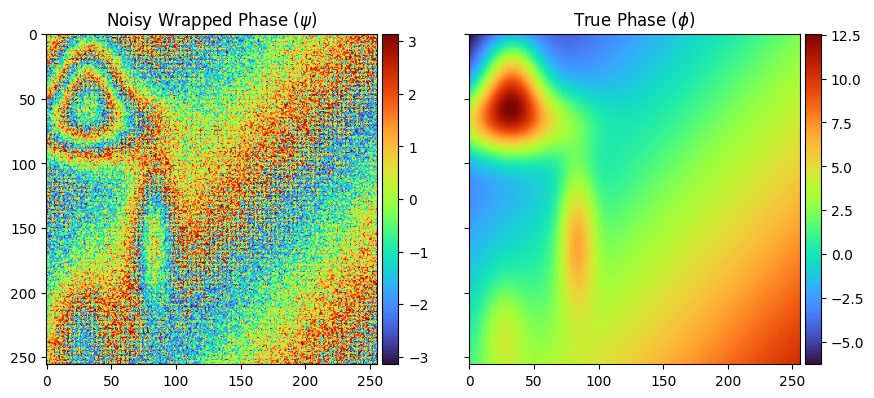

In [11]:
# 08

## visualize a pair
idx = np.random.randint(0, X.shape[0])
plot(X[idx], y[idx], titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)"])


matOrg_tr = {"data":I,"label": "original data"}
savemat("matPYorig_tr1.mat", matOrg_tr)

matWrap_tr = {"data":I_wrap,"label": "wrapped data"}
savemat("matPYwrap_tr1.mat", matWrap_tr)

# Compile the Model


In [13]:
# 09

model = denseNetPU_v5()
model.summary()

model_id = 'Model_{}'.format(dataset_id)
model_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/{}.h5'.format(model_id)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    #optimizer=Adam(learning_rate=1e-3, decay=0.001),
    #optimizer=SGD(learning_rate=1e-4),
    loss=tv_loss_plus_var_loss
)

earlystopper = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='loss',
    verbose=1,
    save_best_only=True
)

2023-09-12 17:06:22.863143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 17:06:22.874337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-09-12 17:06:22.876497: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-12 17:06:22.877023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Train the Model

In [175]:
# 10

## train the model
history = model.fit(
    x = X.reshape(X.shape[0], 256, 256, 1),
    y = y.reshape(y.shape[0], 256, 256, 1),
    batch_size=16,
    epochs=100, 
    verbose=1,
    callbacks=[model_checkpoint, earlystopper]   
)

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 41.9800
Epoch 1: loss improved from inf to 41.98000, saving model to /home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Model_Noisy_Phase_Data_6000_8pi_8pi.h5
375/375 [==============================] - 2015s 5s/step - loss: 41.9800
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 28.7035
Epoch 2: loss improved from 41.98000 to 28.70345, saving model to /home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Model_Noisy_Phase_Data_6000_8pi_8pi.h5
375/375 [==============================] - 2003s 5s/step - loss: 28.7035
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 13.8817
Epoch 3: loss improved from 28.70345 to 13.88170, saving model to /home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Model_Noisy_Phase_Data_6000_8pi_8pi.h5
375/375 [==============================] - 1999s 5s/step - loss: 13.8817
Epoch 4/100
375

# Model Convergence

In [1]:
# 11

loss = history.history['loss']
epochs = np.arange(0, len(loss), 1)
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs. Loss")
plt.grid()
plt.show

NameError: name 'history' is not defined

# Test Data Create, Load and Visualize

In [ ]:
# 12

## create a test dataset (run only once unless there's no need to create a new test set)
save_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Data_Noisy Phase'
size = (256, 256)
no_samples = 400
max_lower_bound = 4
max_upper_bound = 4 
noise_levels = [0, 10, 25, 50, 100]

create_dataset(save_path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels)

In [7]:
# 13

## load the test dataset 
dataset_id = 'Noisy_Phase_Data_400_8pi_8pi'
save_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Data_Noisy Phase/{}.hdf5'.format(dataset_id)
dataset = h5py.File(save_path, mode='r')
X_test = np.array(dataset['psi'])
y_test = np.array(dataset['phi'])

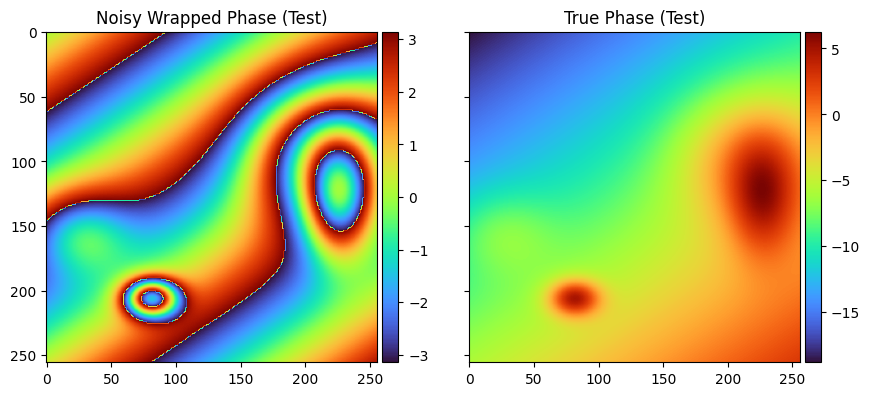

In [8]:
# 14

## visualize a pair
idx = np.random.randint(0, X_test.shape[0])
#plot(X[idx], y[idx], titles=["Noisy Wrapped Phase (Test)", "True Phase (Test)"])
plot(X_test[idx], y_test[idx], titles=["Noisy Wrapped Phase (Test)", "True Phase (Test)"])

#matOrg_tst = {"data":I,"label": "original data"}
#savemat("matPYorig_tst.mat", matOrg_tst)

#matWrap_tst = {"data":I_wrap,"label": "wrapped data"}
#savemat("matPYwrap_tst.mat", matWrap_tst)

# Predict True Phase from Wrapped Phase

In [9]:
# 15

## load trained model
model = denseNetPU_v5()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    #optimizer=SGD(learning_rate=1e-4),
    metrics=[]
)

# model_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data/Model_Noisy_Phase_Data_1000_8pi_8pi.h5'
model_path = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Model_Noisy_Phase_Data_6000_8pi_8pi.h5'
model.load_weights(model_path)

2023-09-28 16:46:10.074520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-28 16:46:10.077005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-09-28 16:46:10.077398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-28 16:46:10.077616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [10]:
# 16

## predict true phase
y_pred = model.predict(X_test, batch_size=16)

25/25 [==============================] - 23s 851ms/step


Due to the nature of the porblem of phase unwrapping, for each wrapped phase $\psi$, there exists a family of solutions (true phases) charactersized by $\phi + 2n\pi, \; n \in \mathbb{Z}$. To avoid this ambiguity when computing the accuracy metrics, we rescale the predicted true phase values ($\hat{\phi}$) to match scale of the true phase values ($\phi$).

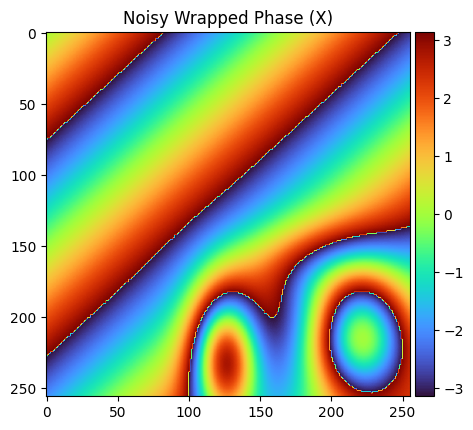

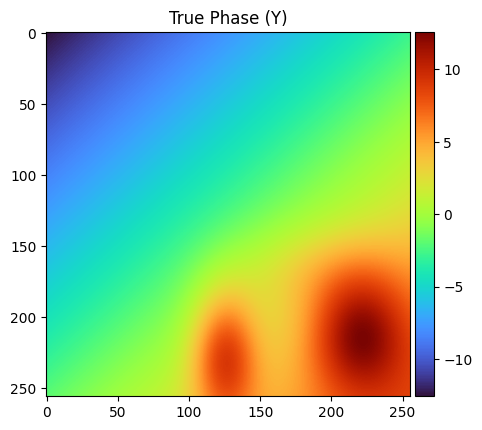

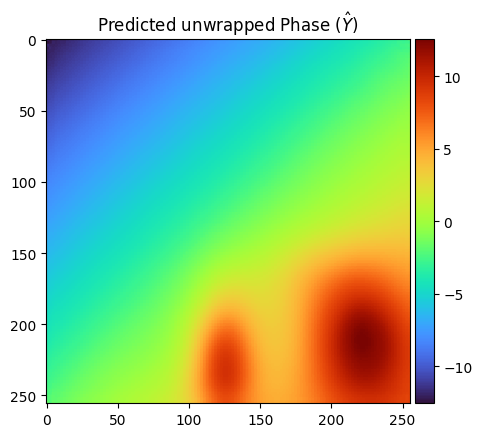

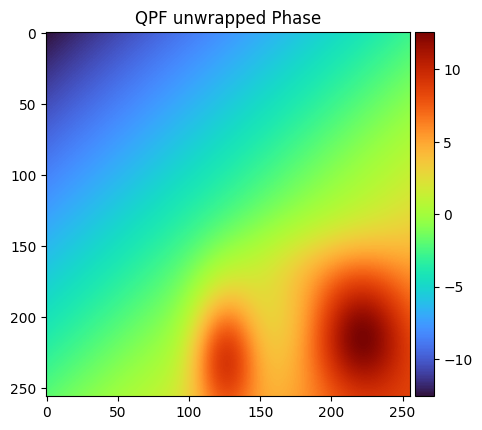

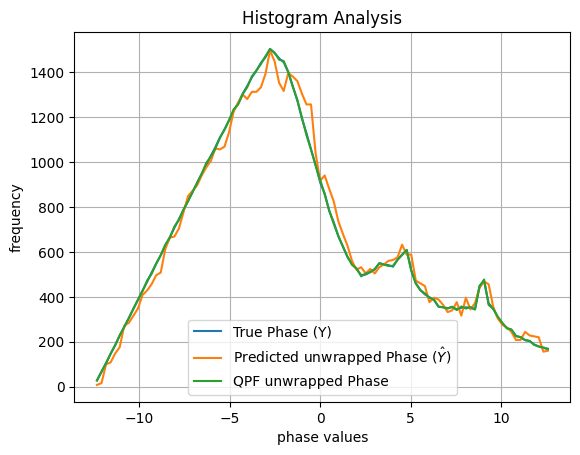

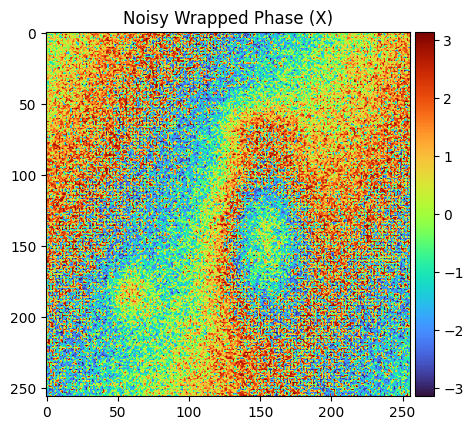

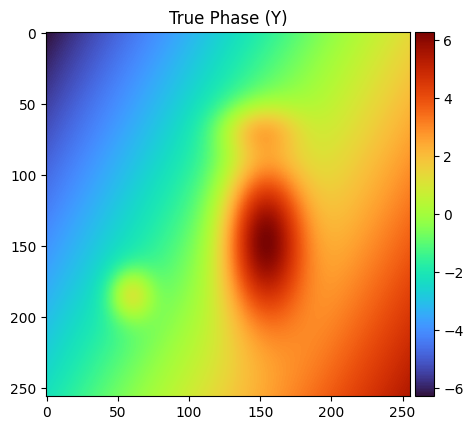

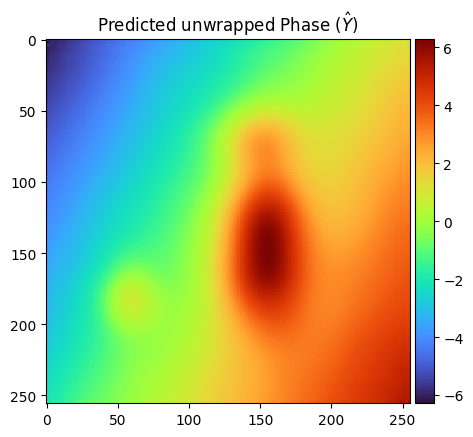

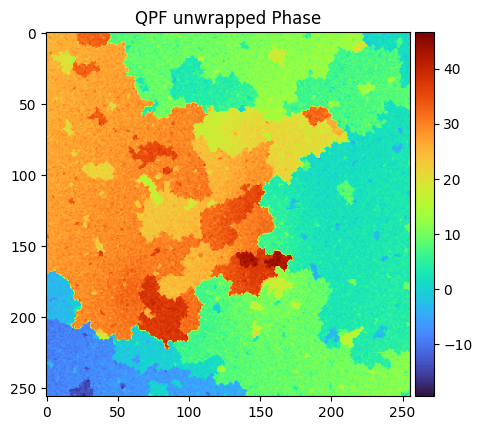

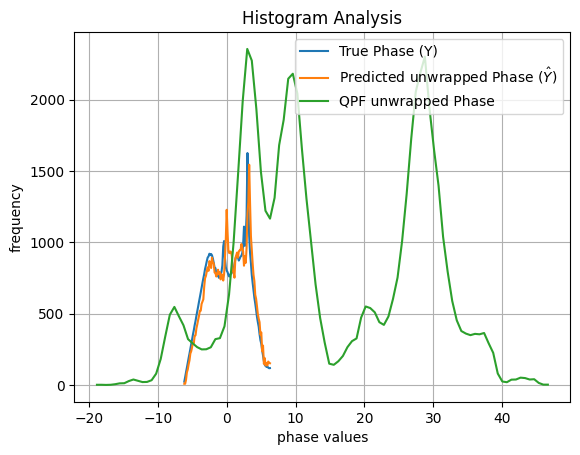

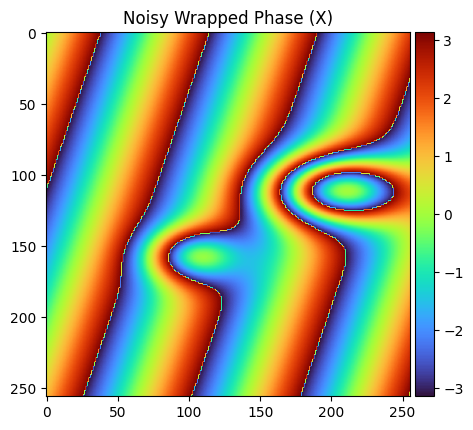

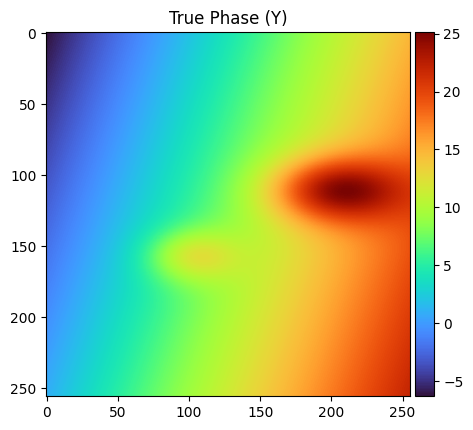

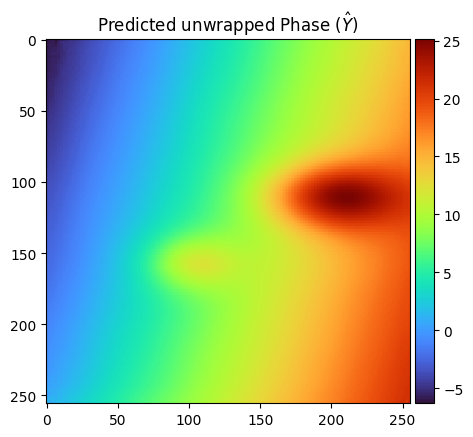

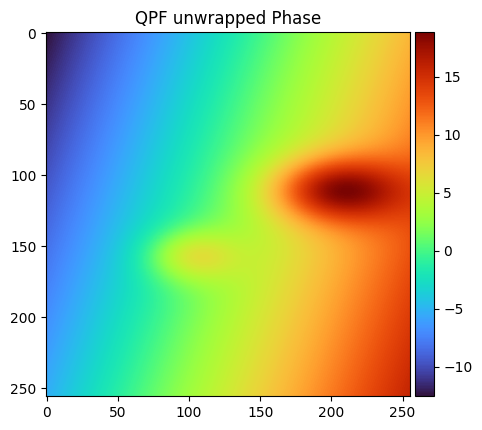

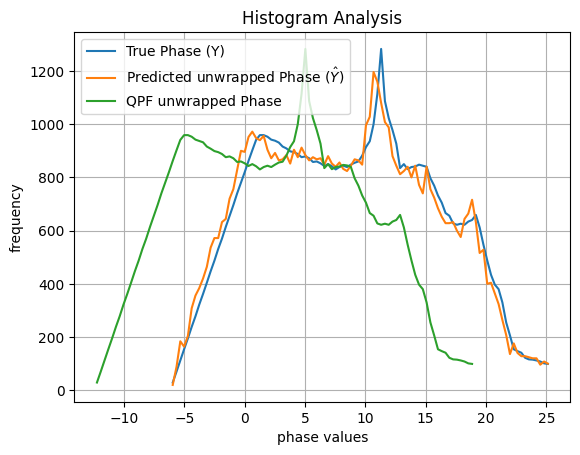

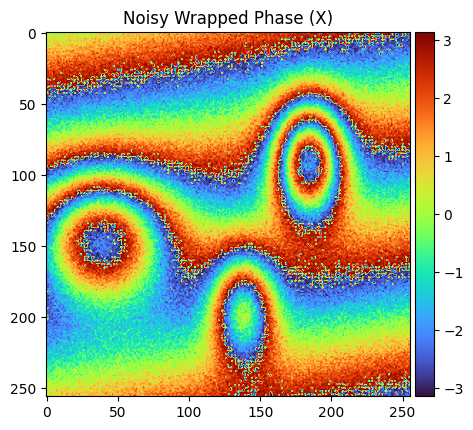

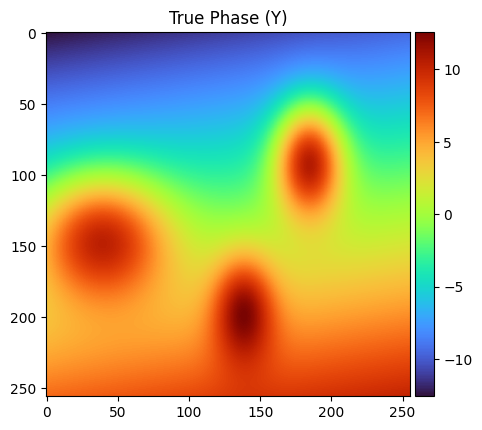

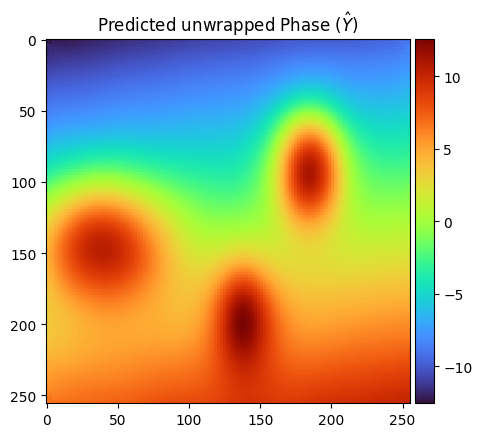

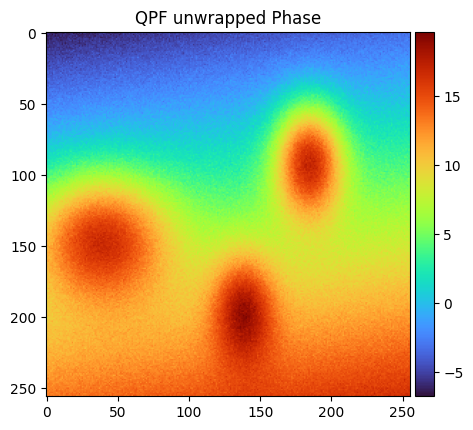

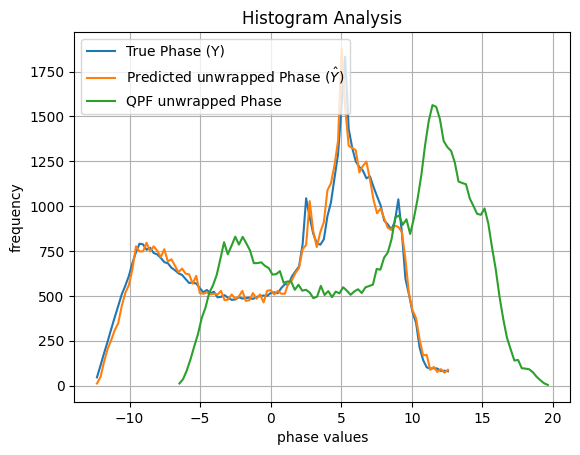

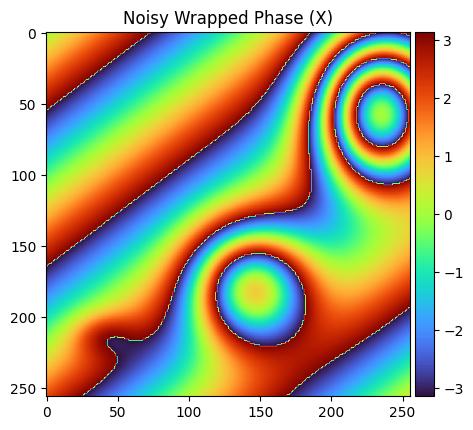

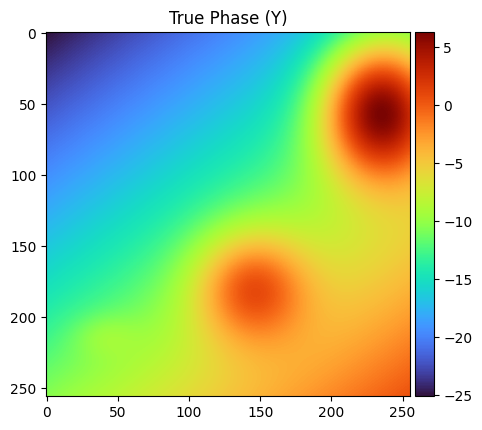

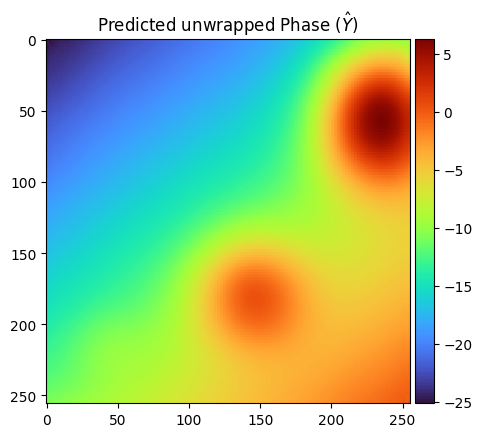

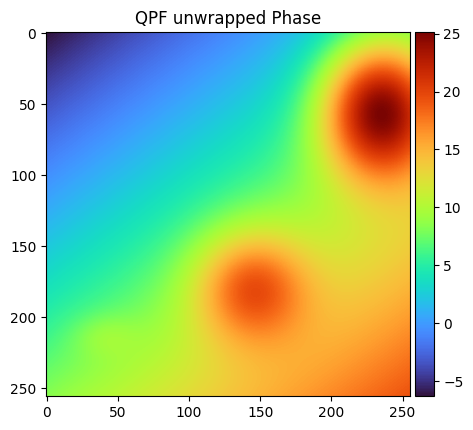

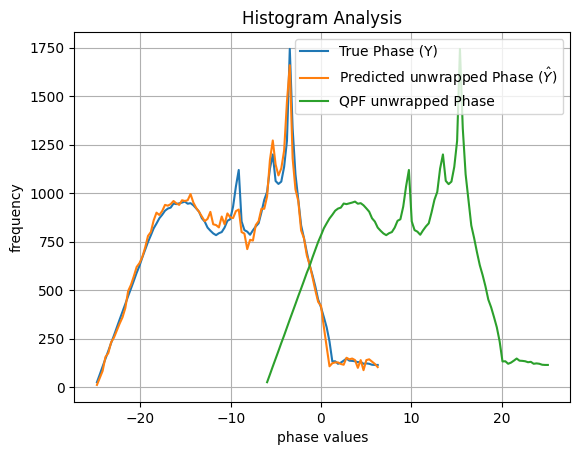

In [16]:
# 17

## visualize
y_pred_scaled = np.empty((0, 256, 256))
 
for i in range(5):
  Xi = X_test[i]
  yi = y_test[i]
  ypi = y_pred[i]
  
  # match scales of predicted true phase
  min1, max1 = np.min(yi), np.max(yi)
  min2, max2 = np.min(ypi), np.max(ypi)
  temp = (ypi - min2) / (max2 - min2)
  ypi_scaled = temp * (max1 - min1) + min1
  y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))

  squeezed_arr = np.squeeze(ypi_scaled)
  
  Difference = yi - squeezed_arr 

  #QPF Algorithm
  QPF_unwrapped = unwrap_phase(Xi)

  # visualize
  #plot(Xi, yi, ypi_scaled, titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
  plot(Xi, titles="Noisy Wrapped Phase (X)")
  plot(yi, titles="True Phase (Y)")
  plot(ypi_scaled, titles="Predicted unwrapped Phase ($\hat{Y}$)")
  plot(QPF_unwrapped, titles="QPF unwrapped Phase")
  plot_hist(yi, ypi_scaled,QPF_unwrapped, titles=["True Phase (Y)", "Predicted unwrapped Phase ($\hat{Y}$)","QPF unwrapped Phase"])
  #plot(Difference, titles="Difference map (Y) and ($\hat{Y}$) ")


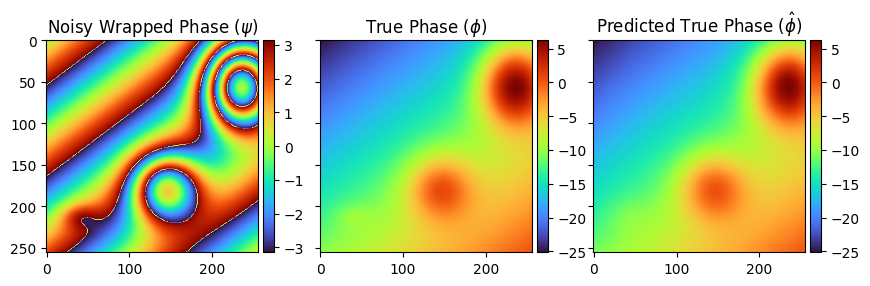

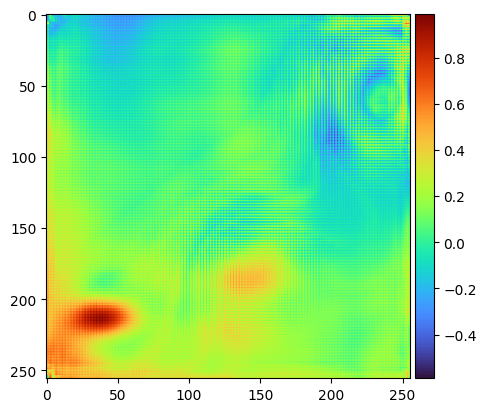

In [15]:
# Testing of Difference 

squeezed_arr = np.squeeze(ypi_scaled)

Difference = yi - squeezed_arr 

plot(Xi, yi, ypi_scaled, titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
plot(Difference)

# QGPU Algorithm

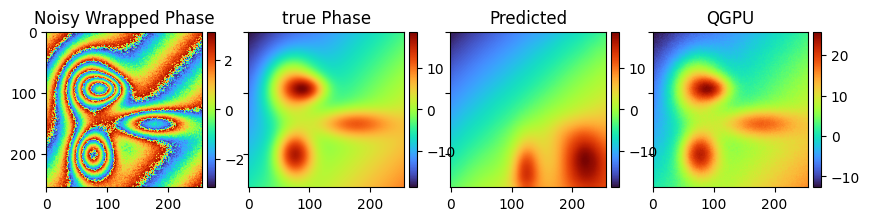

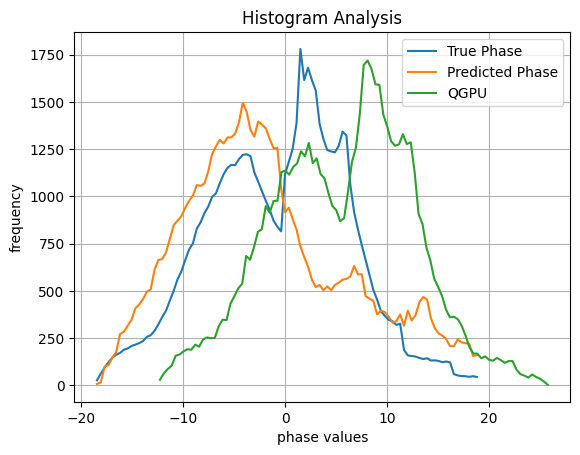

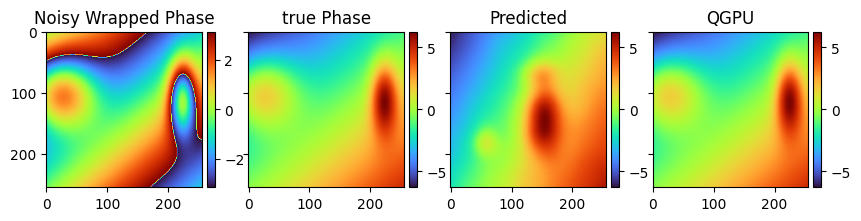

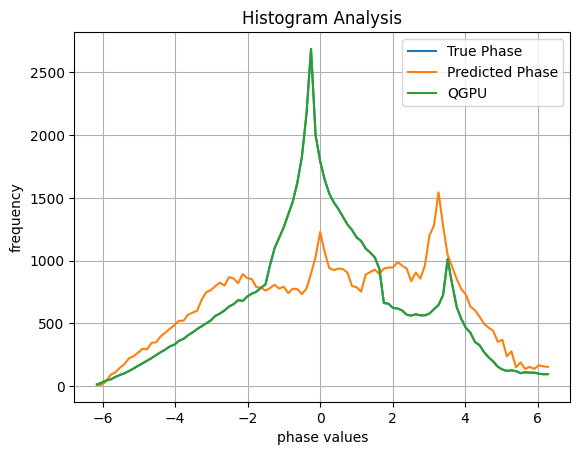

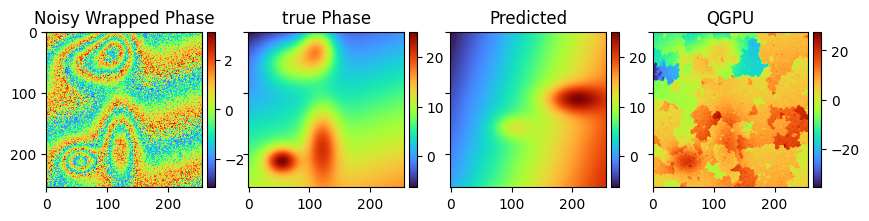

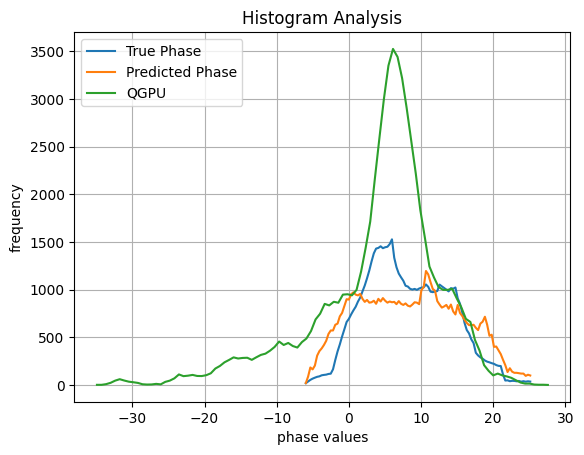

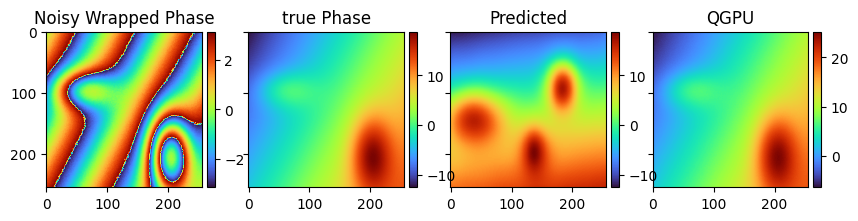

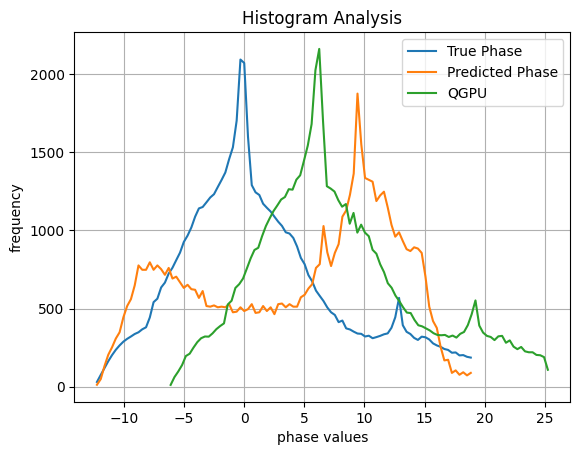

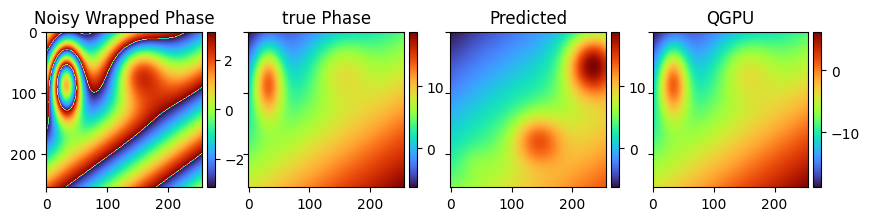

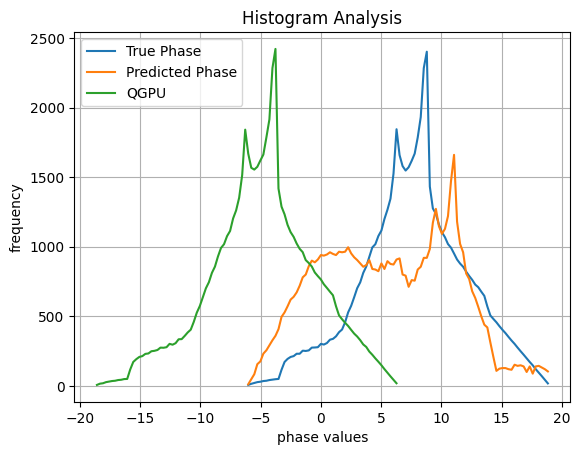

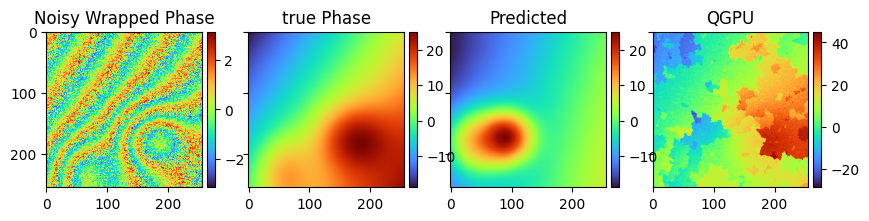

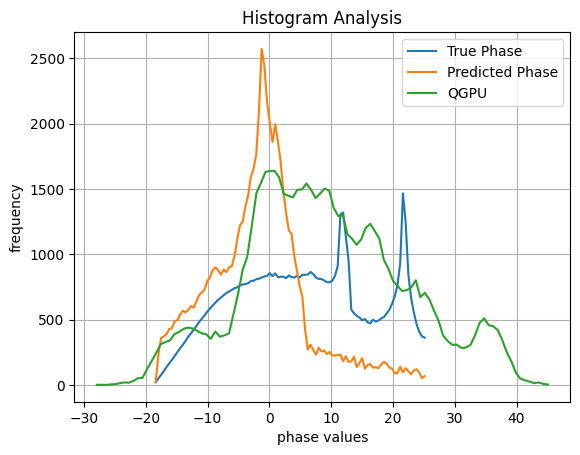

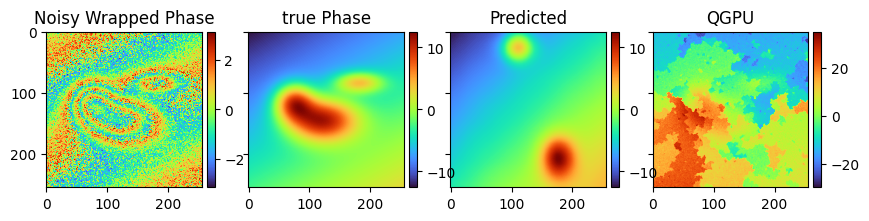

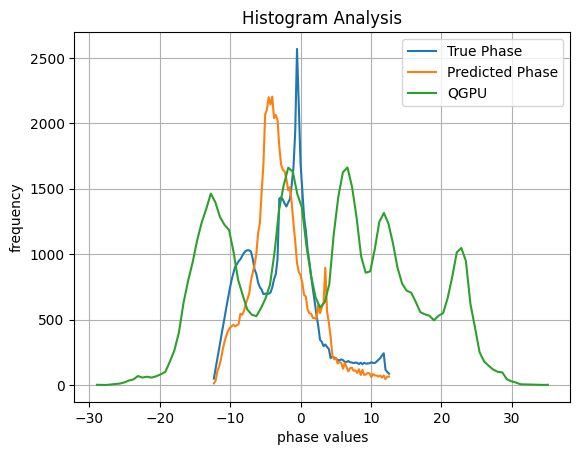

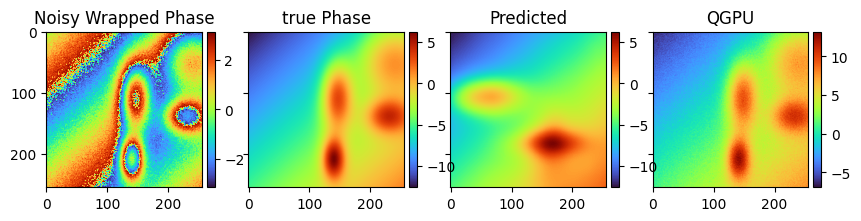

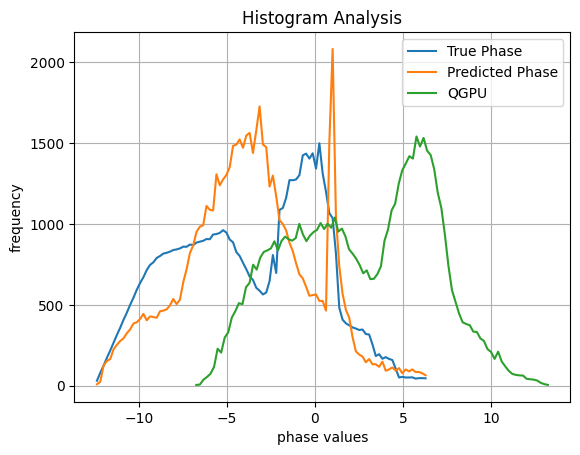

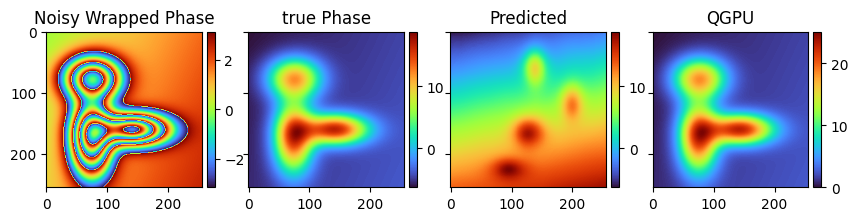

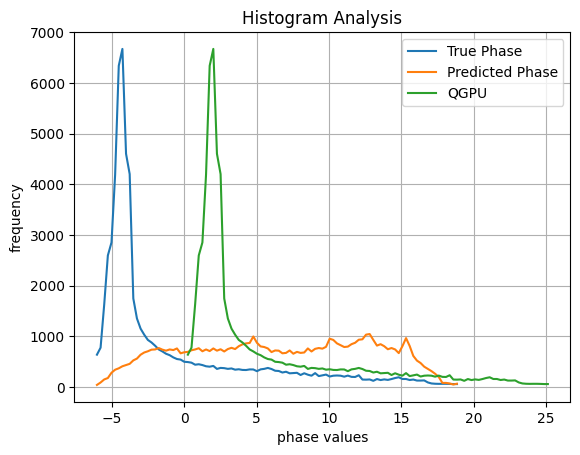

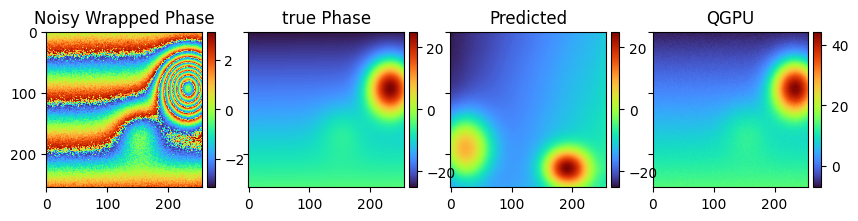

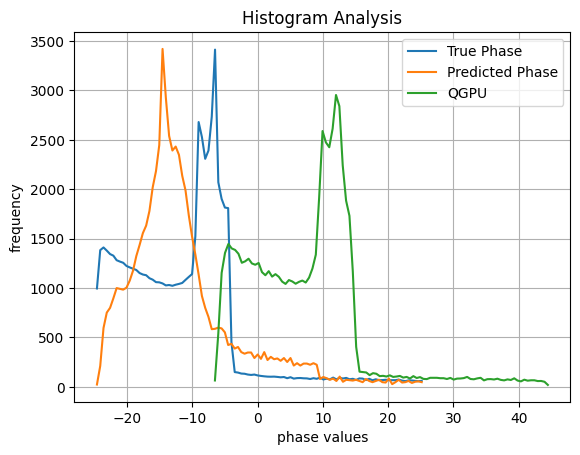

In [21]:
# Open Data

dataset_id = 'Noisy_Phase_Data_1000_8pi_8pi'
data = '/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Data_Noisy Phase/{}.hdf5'.format(dataset_id)
dataset = h5py.File(data, mode='r')
X_test = np.array(dataset['psi'])
Y_test = np.array(dataset['phi'])

Y_pred = []

for i in range(10):
    image_wrapped = X_test[i]
    yi = Y_test[i]
    image_unwrapped = unwrap_phase(image_wrapped)
    ypi = y_pred[i]

    # match scales of predicted true phase
    min1, max1 = np.min(yi), np.max(yi)
    min2, max2 = np.min(ypi), np.max(ypi)
    temp = (ypi - min2) / (max2 - min2)
    ypi_scaled = temp * (max1 - min1) + min1
    y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))
    
    plot(image_wrapped,yi,ypi_scaled, image_unwrapped, titles=["Noisy Wrapped Phase","true Phase","Predicted", "QGPU"])
    plot_hist(yi, ypi_scaled, image_unwrapped, titles=["True Phase","Predicted Phase", "QGPU"])


# Experimental Data Check

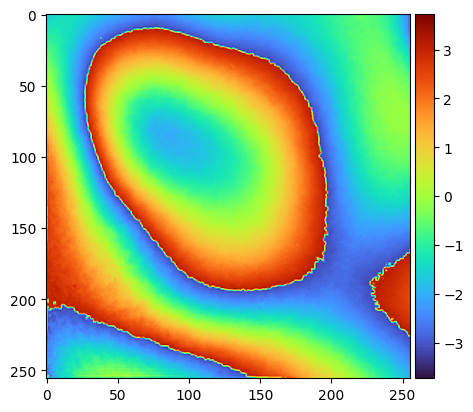

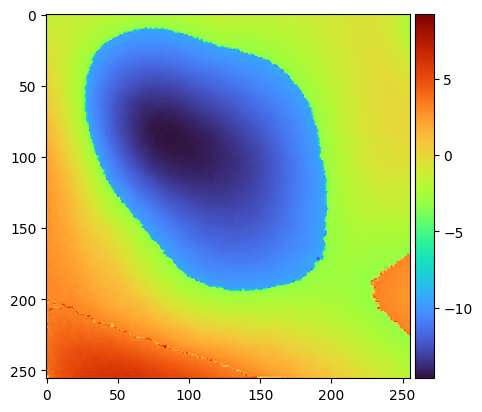

'\n\nfor i in range(10):\n    image_wrapped = X_test[i]\n    yi = y_test[i]\n    image_unwrapped = unwrap_phase(image_wrapped)\n    ypi = y_pred[i]\n\n    # match scales of predicted true phase\n    min1, max1 = np.min(yi), np.max(yi)\n    min2, max2 = np.min(ypi), np.max(ypi)\n    temp = (ypi - min2) / (max2 - min2)\n    ypi_scaled = temp * (max1 - min1) + min1\n    y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))\n    \n    plot(image_wrapped,yi,ypi_scaled, image_unwrapped, titles=["Noisy Wrapped Phase","true Phase","Predicted", "QGPU"])\n    plot_hist(yi, ypi_scaled, image_unwrapped, titles=["True Phase","Predicted Phase", "QGPU"])\n\n\n'

In [36]:
# Experimental Data

data = loadmat("/home/aws/Awais_Work/DenSePU_Paper_Aws01/Folder_01/Folder_02/Data_Models/Data_Noisy Phase/data217.mat")
dataset = data['data']
rearranged = np.moveaxis(dataset,2,0)
idx = np.random.randint(0, rearranged.shape[0])
idy = np.random.randint(0, rearranged.shape[0])
x = rearranged[75]
X_expTest = np.reshape(x, (1,256,256))

plot(X_expTest)

image_unwrapped = unwrap_phase(x)

plot(image_unwrapped)

'''

for i in range(10):
    image_wrapped = X_test[i]
    yi = y_test[i]
    image_unwrapped = unwrap_phase(image_wrapped)
    ypi = y_pred[i]

    # match scales of predicted true phase
    min1, max1 = np.min(yi), np.max(yi)
    min2, max2 = np.min(ypi), np.max(ypi)
    temp = (ypi - min2) / (max2 - min2)
    ypi_scaled = temp * (max1 - min1) + min1
    y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))
    
    plot(image_wrapped,yi,ypi_scaled, image_unwrapped, titles=["Noisy Wrapped Phase","true Phase","Predicted", "QGPU"])
    plot_hist(yi, ypi_scaled, image_unwrapped, titles=["True Phase","Predicted Phase", "QGPU"])


'''

1/1 [==============================] - 0s 115ms/step


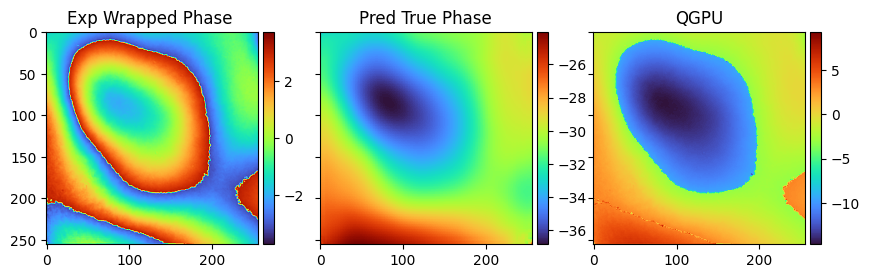

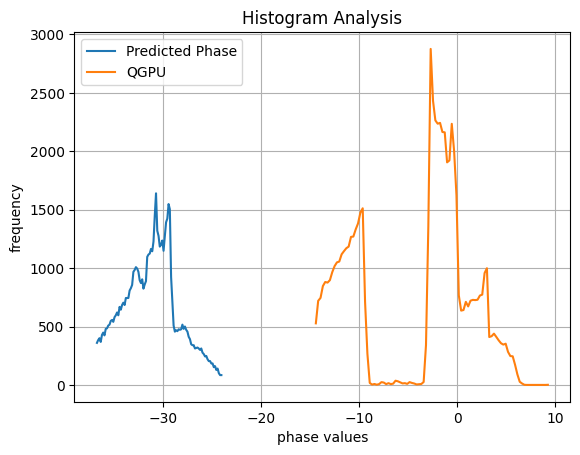

In [37]:
## visualize Experimental Data

y_predexp = model.predict(X_expTest, batch_size=1)

y_pred_scaledexp = np.empty((0, 256, 256))
for i in range(1):
  Xi = X_expTest[i]
  #yi = Y_expTest[i]
  ypi = y_predexp[i]
  
  # match scales of predicted true phase
  #min1, max1 = np.min(yi), np.max(yi)
  #min2, max2 = np.min(ypi), np.max(ypi)
  #temp = (ypi - min2) / (max2 - min2)
  #ypi_scaled = temp * (max1 - min1) + min1
  #ypi_scaled = (max1 - min1) + min1
  # visualize
  #plot(Xi, yi, ypi_scaled, titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
  #plot_hist(yi, ypi_scaled, titles=["True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
  plot(Xi, ypi, image_unwrapped, titles=["Exp Wrapped Phase ","Pred True Phase","QGPU"])
  plot_hist(ypi, image_unwrapped, titles=["Predicted Phase", "QGPU"])
 

# Get Accuracy Metrics

We use Normalized Root Mean Squared Error (NRMSE) to report the performance of our method.

$$ \text{NRMSE} = \frac{\sqrt{\mathbb{E}\big[(\phi - \hat{\phi})^2\big]}}{\phi_{max} - \phi_{min}} $$

In [38]:
# 18

## get the scaled predicted true phase values
y_pred_scaled = np.empty((0, 256, 256))
for i in range(X_test.shape[0]):
  Xi = X_test[i]
  yi = y_test[i]
  ypi = y_pred[i]
  
  # match scales of predicted true phase
  min1, max1 = np.min(yi), np.max(yi)
  min2, max2 = np.min(ypi), np.max(ypi)
  temp = (ypi - min2) / (max2 - min2)
  ypi_scaled = temp * (max1 - min1) + min1
  y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))

IndexError: index 400 is out of bounds for axis 0 with size 400

In [20]:
# 19

## compute NRMSE
error = y_test - y_pred_scaled
r = np.max(y_test, axis=(1, 2), keepdims=True) - np.min(y_test, axis=(1, 2), keepdims=True)
NRMSE = np.mean(np.sqrt(np.mean(error**2, axis=(1, 2)))/r)*100
performance = "NRMSE = {:.2f} %".format(NRMSE)
print(performance)

NRMSE = 1.30 %


$$ \ast \; \ast \; \ast$$